In [1]:
import tensorflow as tf
import numpy as np

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)

y_train_cls = y_train.astype(np.int32)
y_test_cls = y_test.astype(np.int32) 

y_train = np.eye(10)[y_train].astype(np.float32)
y_test = np.eye(10)[y_test].astype(np.float32) 

print(x_train.shape, x_train.dtype) 
print(y_train.shape, y_train.dtype) 
print(y_train_cls.shape, y_train_cls.dtype) 
print(x_test.shape, x_test.dtype)  
print(y_test.shape, y_test.dtype)  
print(y_test_cls.shape, y_test_cls.dtype)

(60000, 784) float32
(60000, 10) float32
(60000,) int32
(10000, 784) float32
(10000, 10) float32
(10000,) int32


In [10]:
lr = 5e-5 
epoch = int(1e2) 
batch_size = 100

layer_widths = [784, 500, 300, 100, 50, 10]
w_shapes = []
previous = layer_widths[0] 
for layer_width in layer_widths[1:]:
    w_shapes.append((previous, layer_width))
    previous = layer_width 
    
import numpy as np; np.random.seed(0)
import tensorflow as tf; tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 784)) # (?, 784)
y = tf.placeholder(tf.float32, (None, 10)) # (?, 10)
y_cls = tf.placeholder(tf.int32, (None,)) # (?,)

init_w = tf.keras.initializers.VarianceScaling(seed=0)
init_b = tf.keras.initializers.zeros()

for i, (pre, layer_width) in enumerate(w_shapes):
    w_name = f'w{i}'
    b_name = f'b{i}'
    w = tf.get_variable(w_name, (pre, layer_width), tf.float32, init_w)
    b = tf.get_variable(b_name, (layer_width,), tf.float32, init_b)
    if i==0:
        x1 = tf.nn.relu(x @ w + b)
    elif i!=len(w_shapes)-1:
        x1 = tf.nn.relu(x1 @ w + b)
    else:
        logits = x1 @ w + b

entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, 
                                                     logits=logits) # (?,)
loss = tf.reduce_mean(entropy) # ()

opt = tf.train.AdamOptimizer(lr)
train = opt.minimize(loss)

y_pred_cls = tf.cast(tf.argmax(logits, axis=1), 
                     tf.int32, name='y_pred_cls') # (?,) int32
correct_bool = tf.equal(y_pred_cls, y_cls, 
                        name='correct_bool') # (?,) bool
accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32), 
                          name='accuracy') # () float32

init = tf.global_variables_initializer()

In [11]:
with tf.Session() as sess:
    
    sess.run(init)
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epoch):
        
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        
        x_epoch = x_train[idx]
        y_epoch = y_train[idx]
        y_cls_epoch = y_train_cls[idx]
        
        for k in range(x_train.shape[0]//batch_size):
            
            if k==0:
                loss_temp = []
                accuracy_temp = []
                
            x_batch = x_epoch[k*batch_size:(k+1)*batch_size]
            y_batch = y_epoch[k*batch_size:(k+1)*batch_size]
            y_cls_batch = y_cls_epoch[k*batch_size:(k+1)*batch_size]
            
            feed_dict = {x:x_batch, y:y_batch, y_cls:y_cls_batch}
            
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], 
                                                 feed_dict=feed_dict)
            
            loss_temp.append(loss_run) 
            accuracy_temp.append(accuracy_run)
        
        loss_avg = np.array(loss_temp).mean()
        accuracy_avg = np.array(accuracy_temp).mean()
        loss_trace.append(loss_avg)
        accuracy_trace.append(accuracy_avg)
        print(f'{i+1}/{epoch} loss {loss_avg}, accuracy {accuracy_avg} ')
    
    feed_dict = {x:x_test, y:y_test, y_cls:y_test_cls}
    accuracy_run, y_test_cls_pred = sess.run([accuracy, y_pred_cls], 
                                             feed_dict=feed_dict)

1/100 loss 0.8565009832382202, accuracy 0.7873333692550659 
2/100 loss 0.27111801505088806, accuracy 0.9234666228294373 
3/100 loss 0.20891894400119781, accuracy 0.9411833882331848 
4/100 loss 0.17351603507995605, accuracy 0.9507499933242798 
5/100 loss 0.14813697338104248, accuracy 0.9579166769981384 
6/100 loss 0.1301204115152359, accuracy 0.9627833962440491 
7/100 loss 0.11499727517366409, accuracy 0.9672499299049377 
8/100 loss 0.10201065242290497, accuracy 0.9710500240325928 
9/100 loss 0.09190388768911362, accuracy 0.9738167524337769 
10/100 loss 0.08274735510349274, accuracy 0.976216733455658 
11/100 loss 0.07544518262147903, accuracy 0.9780333638191223 
12/100 loss 0.06823176145553589, accuracy 0.9801999926567078 
13/100 loss 0.061972085386514664, accuracy 0.9824000000953674 
14/100 loss 0.05637247860431671, accuracy 0.9843165874481201 
15/100 loss 0.05178648978471756, accuracy 0.9848499298095703 
16/100 loss 0.047110628336668015, accuracy 0.9872499704360962 
17/100 loss 0.0428

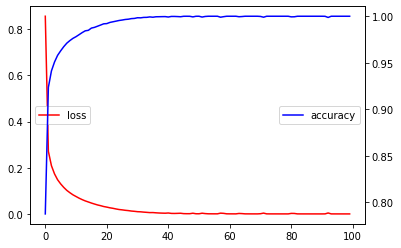

In [12]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(loss_trace, color='red', label='loss')
plt.legend(loc='center left')

ax2 = ax1.twinx() 
ax2.plot(accuracy_trace, color='blue', label='accuracy')
plt.legend(loc='center right')

plt.show()

In [13]:
print(f'Test Period Accuracy : {accuracy_run}')

Test Period Accuracy : 0.9801999926567078


In [14]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
print(cm)

[[ 969    0    0    1    1    1    2    1    4    1]
 [   0 1124    4    1    0    0    2    1    3    0]
 [   4    0 1010    2    1    0    4    3    6    2]
 [   0    1    4  995    0    2    0    3    3    2]
 [   0    0    3    0  967    0    4    2    2    4]
 [   2    0    0    8    1  868    4    1    5    3]
 [   6    2    1    0    5    5  938    0    1    0]
 [   2    6    8    3    2    0    0  999    3    5]
 [   2    0    3    8    1    3    1    2  951    3]
 [   2    2    0    4    9    4    0    4    3  981]]


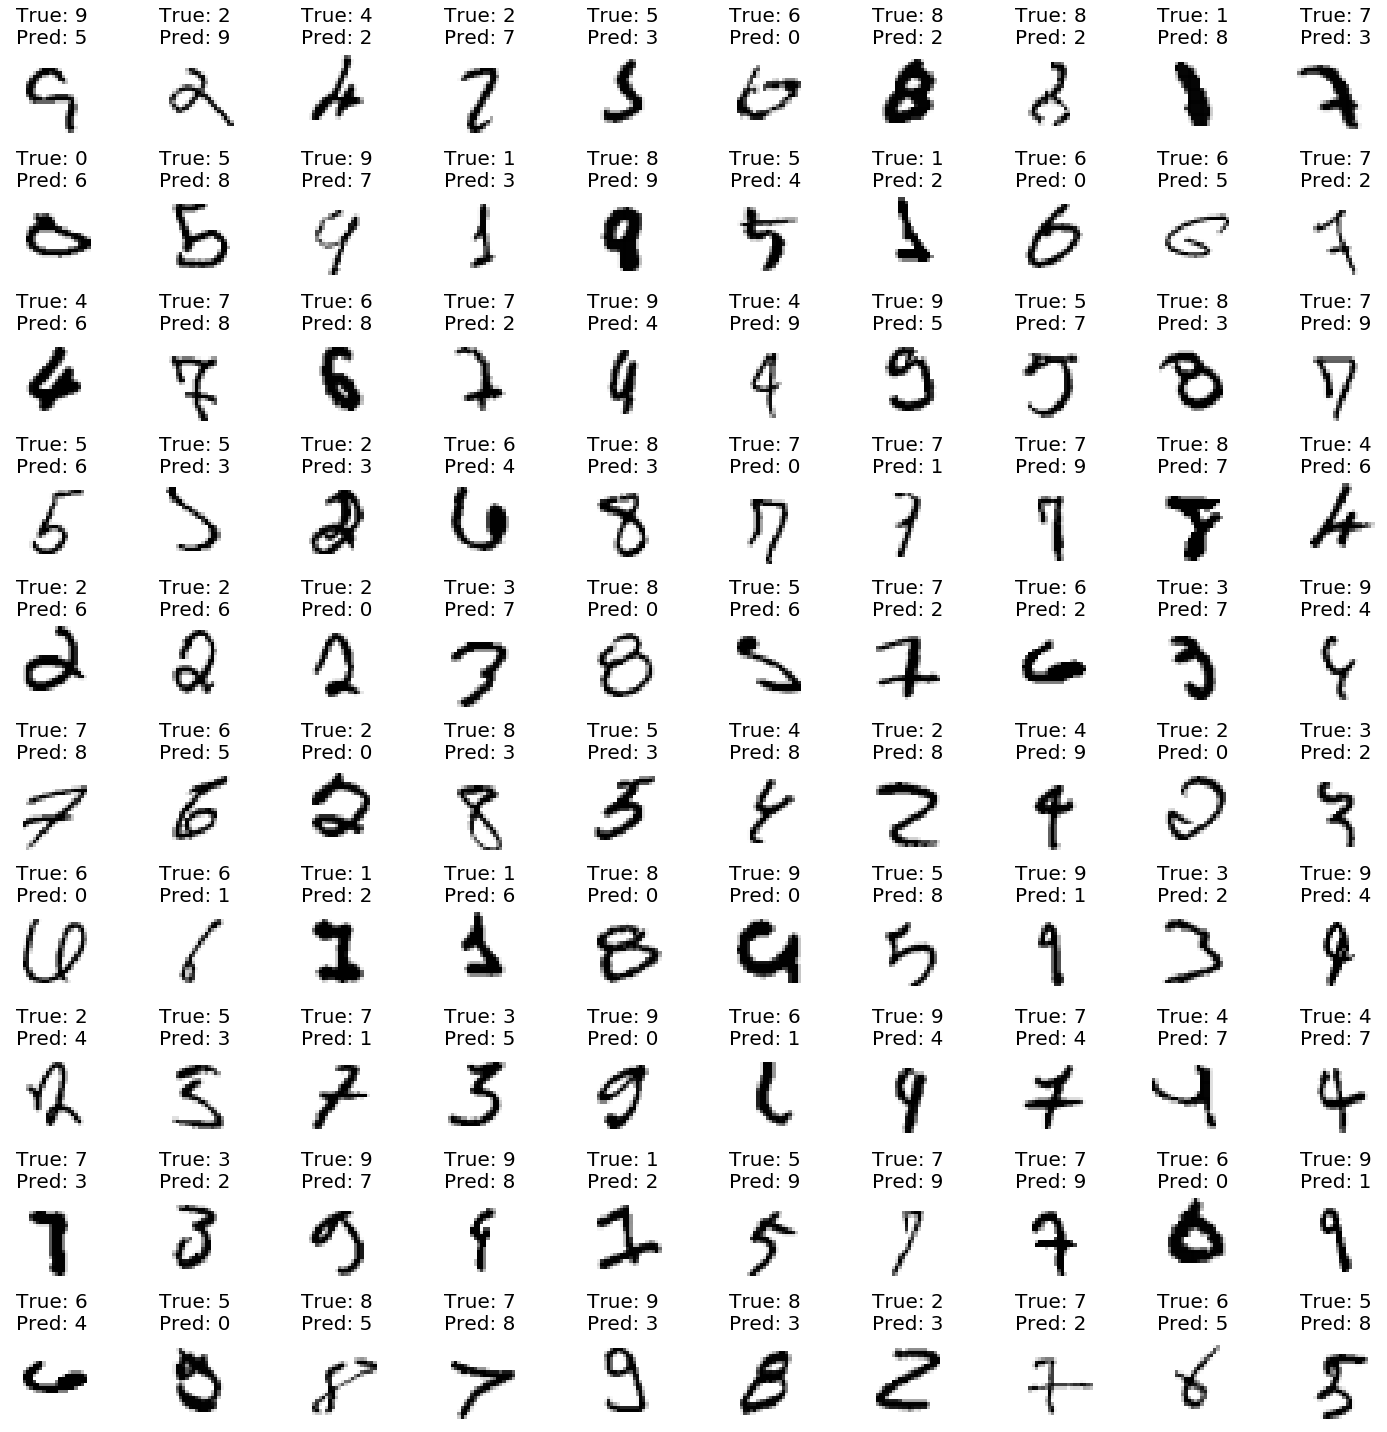

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20,20))

idx = 0
for ax in axes.reshape((-1,)): # (2, 10) ---> (20,)
    while True:
        if y_test_cls[idx]==y_test_cls_pred[idx]:
            idx += 1
        else:
            ax.imshow(x_test[idx].reshape((28,28)), cmap='binary')
            true_label = y_test_cls[idx]
            pred_label = y_test_cls_pred[idx]
            title = f'True: {true_label}\nPred: {pred_label}'
            ax.set_title(title, fontsize=20)
            ax.axis('off')
            idx += 1
            break
            
plt.tight_layout()

plt.show()